In [31]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_fscore_support,
    average_precision_score, precision_recall_curve
)
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Notebook options
pd.set_option('display.max_columns', 100)


## Load and inspect data

In [5]:
CSV_PATH = 'creditcard.csv'  

df = pd.read_csv(CSV_PATH)
assert 'Time' in df.columns and 'Amount' in df.columns and 'Class' in df.columns, "Dataset columns missing"
print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Preprocess: sort by time, engineer `TimeDelta`, scale features

In [7]:

# Sort by time to respect temporal order
df = df.sort_values('Time').reset_index(drop=True)

# Engineer time delta feature (seconds between transactions)
df['TimeDelta'] = df['Time'].diff().fillna(0.0)

# Features: V1..V28 + Amount + TimeDelta
feature_cols = [c for c in df.columns if c.startswith('V')]
feature_cols += ['Amount', 'TimeDelta']

X_all = df[feature_cols].values.astype('float64')
y_all = df['Class'].values.astype(int)

# Chronological split indices later require sequences; scaling should use only *train* portion to avoid leakage.
# We'll temporarily keep X_all unscaled; once sequences and splits are formed, we fit scaler on train only.
print(f"Using {len(feature_cols)} features:", feature_cols)


Using 30 features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'TimeDelta']


## Build fixed-length sequences (non-overlapping windows)

In [9]:

SEQ_LEN = 20  
STEP = SEQ_LEN  # non-overlapping windows

def build_sequences(X, y, seq_len=20, step=None):
    if step is None:
        step = seq_len
    X_seq = []
    y_seq = []
    idx_seq = []
    n = len(X)
    for start in range(0, n - seq_len + 1, step):
        end = start + seq_len
        X_seq.append(X[start:end])
        # Sequence label: 1 if any fraud present in the window
        y_seq.append(int(np.any(y[start:end] == 1)))
        idx_seq.append((start, end))
    return np.array(X_seq, dtype=object), np.array(y_seq), np.array(idx_seq)

X_seq, y_seq, idx_seq = build_sequences(X_all, y_all, seq_len=SEQ_LEN, step=STEP)
print("Num sequences:", len(X_seq), "Sequence shape example:", X_seq[0].shape)
print("Positive (fraud) sequences:", y_seq.sum())


Num sequences: 14240 Sequence shape example: (20, 30)
Positive (fraud) sequences: 425


## Chronological Train/Val/Test split at the **sequence level**

In [11]:

def chrono_split(n, train_ratio=0.6, val_ratio=0.2):
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train_idx = np.arange(0, n_train)
    val_idx = np.arange(n_train, n_train + n_val)
    test_idx = np.arange(n_train + n_val, n)
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = chrono_split(len(X_seq), 0.6, 0.2)

X_train_raw, y_train = X_seq[train_idx], y_seq[train_idx]
X_val_raw,   y_val   = X_seq[val_idx],   y_seq[val_idx]
X_test_raw,  y_test  = X_seq[test_idx],  y_seq[test_idx]

print("Sequences ->", len(X_train_raw), len(X_val_raw), len(X_test_raw))
print("Fraud counts -> Train:", y_train.sum(), "Val:", y_val.sum(), "Test:", y_test.sum())


Sequences -> 8544 2848 2848
Fraud counts -> Train: 299 Val: 54 Test: 72


## Scale features using **train only** (to avoid leakage)

In [13]:

scaler = StandardScaler()

# Fit on train 
X_train_stack = np.vstack(X_train_raw)
scaler.fit(X_train_stack)

def scale_seq_list(X_list):
    return [scaler.transform(x) for x in X_list]

X_train = scale_seq_list(X_train_raw)
X_val   = scale_seq_list(X_val_raw)
X_test  = scale_seq_list(X_test_raw)

lengths_train = [len(x) for x in X_train]
lengths_val   = [len(x) for x in X_val]
lengths_test  = [len(x) for x in X_test]

print("Scaled. Example sequence shape:", X_train[0].shape)


Scaled. Example sequence shape: (20, 30)


## Train `GaussianHMM` on **normal** train sequences only

In [23]:
N_STATES = 4

# --- sticky priors (states tend to persist within a 20-step window)
startprob = np.full(N_STATES, 1.0 / N_STATES)
A = np.full((N_STATES, N_STATES), 1.0)
np.fill_diagonal(A, 10.0)      # bias to self-transitions
A = A / A.sum(axis=1, keepdims=True)

# --- train on normal sequences only (unchanged)
X_train_norm = [X_train[i] for i in range(len(X_train)) if y_train[i] == 0]
lengths_train_norm = [len(x) for x in X_train_norm]
X_train_norm_stack = np.vstack(X_train_norm)
print("Train-normal samples:", X_train_norm_stack.shape, "Num sequences:", len(X_train_norm))

# --- stabilized HMM
model = GaussianHMM(
    n_components=N_STATES,
    covariance_type="diag",   # more stable than 'full' in 30-D
    n_iter=200,
    tol=1e-3,
    min_covar=1e-3,          # regularize tiny variances
    random_state=RANDOM_STATE,
    verbose=True
)

# keep our priors; only means/covars will be (re)initialized
model.startprob_ = startprob
model.transmat_  = A
model.init_params = "mc"      # do not re-init startprob/transmat

model.fit(X_train_norm_stack, lengths=lengths_train_norm)
print("HMM trained (stabilized).")


Train-normal samples: (164900, 30) Num sequences: 8245


         1 -6704643.25336615             +nan
         2 -6030772.19916194 +673871.05420421
         3 -5587016.28404523 +443755.91511671
         4 -5458984.99718706 +128031.28685817
         5 -5380852.35192433  +78132.64526273
         6 -5353359.02586937  +27493.32605496
         7 -5338002.69876226  +15356.32710711
         8 -5326103.46133281  +11899.23742945
         9 -5316978.63645554   +9124.82487727
        10 -5308212.99827341   +8765.63818214
        11 -5296189.12853192  +12023.86974148
        12 -5290513.37630312   +5675.75222881
        13 -5289034.21619364   +1479.16010948
        14 -5288404.27624376    +629.93994987
        15 -5288000.89422105    +403.38202271
        16 -5287650.17702253    +350.71719852
        17 -5287302.42417843    +347.75284411
        18 -5286935.47459631    +366.94958212
        19 -5286536.50293772    +398.97165859
        20 -5286096.16638804    +440.33654967
        21 -5285602.34754283    +493.81884521
        22 -5285030.33413995    +5

HMM trained (stabilized).


        48 -5188979.38851762      +0.00071082


## Score sequences by **log-likelihood**

In [25]:

def seq_loglik(model, X_list):
    # Returns per-sequence log-likelihood
    scores = []
    for x in X_list:
        try:
            scores.append(model.score(x))
        except Exception as e:
            # In rare cases, model may underflow; fall back to a very low score
            scores.append(-1e12)
    return np.array(scores, dtype=float)

train_scores = seq_loglik(model, X_train)
val_scores   = seq_loglik(model, X_val)
test_scores  = seq_loglik(model, X_test)

print("Score ranges -> train:", (float(np.min(train_scores)), float(np.max(train_scores))))
print("Score ranges -> val:", (float(np.min(val_scores)), float(np.max(val_scores))))
print("Score ranges -> test:", (float(np.min(test_scores)), float(np.max(test_scores))))


Score ranges -> train: (-5896.444529908884, -331.0739792369417)
Score ranges -> val: (-1577.2607428683818, -615.3564040845347)
Score ranges -> test: (-6252.403536778723, -598.5485245286819)


## Choose detection threshold on **validation** to maximize F1 (fraud positive)

In [27]:

# We classify as FRAUD (1) if score < threshold (i.e., very unlikely under normal model)

# Candidate thresholds: use sorted unique val scores + small padding
cands = np.unique(val_scores)
# Add a few percentiles for robustness
for q in [1, 2, 5, 10, 20, 30, 40, 50]:
    cands = np.append(cands, np.percentile(val_scores, q))
cands = np.unique(cands)
best_f1, best_thr, best_prec, best_rec = -1, None, None, None

for thr in cands:
    y_hat = (val_scores < thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_hat, pos_label=1, average='binary', zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr, best_prec, best_rec = f1, thr, prec, rec

print(f"Chosen threshold (val): {best_thr:.4f} | F1={best_f1:.4f} | Precision={best_prec:.4f} | Recall={best_rec:.4f}")
THRESHOLD = best_thr


Chosen threshold (val): -808.1045 | F1=0.1051 | Precision=0.0587 | Recall=0.5000


## Evaluate on **test** sequences

In [35]:
y_pred = (test_scores < THRESHOLD).astype(int)

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

print("\nClassification report (fraud=1):")
print(classification_report(y_test, y_pred, digits=4))

# PR-AUC (fraud positive). (Higher = more likely fraud)
# Since lower log-likelihood = more anomalous, use negative scores.
pr_auc = average_precision_score(y_test, -test_scores)
print(f"PR-AUC (fraud positive): {pr_auc:.4f}")


Confusion Matrix (rows=true, cols=pred):
[[2589  187]
 [  47   25]]

Classification report (fraud=1):
              precision    recall  f1-score   support

           0     0.9822    0.9326    0.9568      2776
           1     0.1179    0.3472    0.1761        72

    accuracy                         0.9178      2848
   macro avg     0.5500    0.6399    0.5664      2848
weighted avg     0.9603    0.9178    0.9370      2848

PR-AUC (fraud positive): 0.0900


## Plots

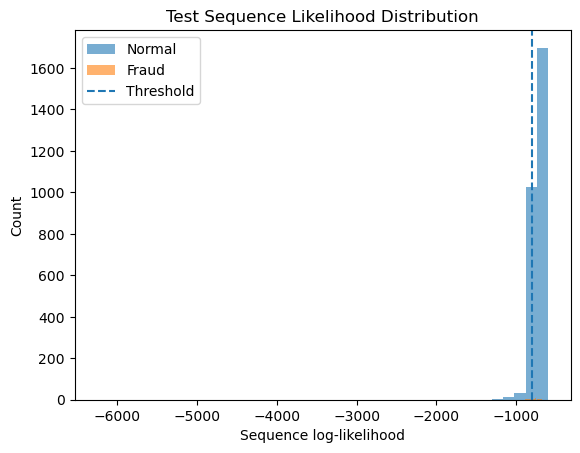

In [37]:

# 1) Histogram of test sequence log-likelihoods split by label
plt.figure()
plt.hist(test_scores[y_test==0], bins=40, alpha=0.6, label='Normal')
plt.hist(test_scores[y_test==1], bins=40, alpha=0.6, label='Fraud')
plt.axvline(THRESHOLD, linestyle='--', label='Threshold')
plt.xlabel('Sequence log-likelihood')
plt.ylabel('Count')
plt.title('Test Sequence Likelihood Distribution')
plt.legend()
plt.show()


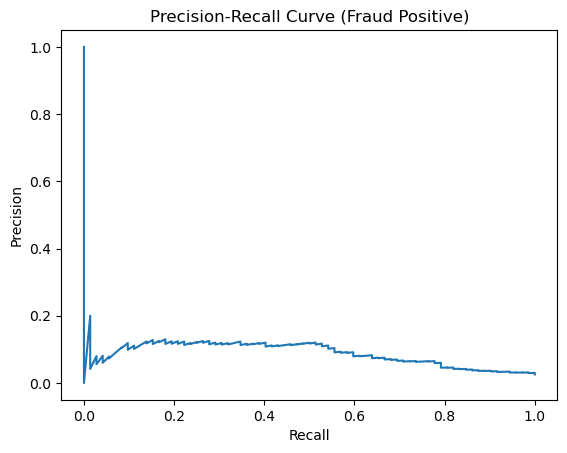

In [39]:

# 2) Precision-Recall curve (fraud positive)
precisions, recalls, thrs = precision_recall_curve(y_test, -test_scores)
plt.figure()
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Fraud Positive)')
plt.show()


## Viterbi state paths (interpretability)

Normal example logprob: -757.1449440879579


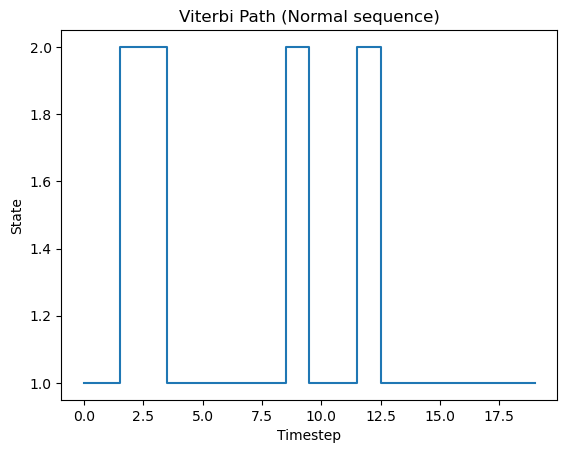

Fraud example logprob: -806.7977619976311


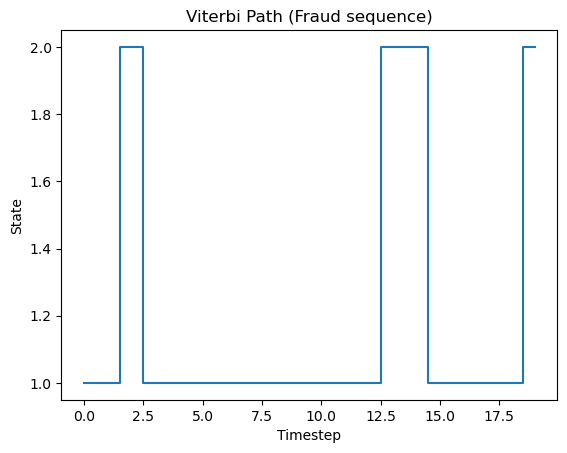

In [41]:

def viterbi_states(model, x):
    # Returns the most likely hidden state sequence for a single sequence x
    logprob, states = model.decode(x, algorithm="viterbi")
    return logprob, states

# Pick one normal and one fraud sequence from test (if present)
normal_idx = None
fraud_idx = None
for i in range(len(X_test)):
    if y_test[i] == 0 and normal_idx is None:
        normal_idx = i
    if y_test[i] == 1 and fraud_idx is None:
        fraud_idx = i

if normal_idx is not None:
    lp, st = viterbi_states(model, X_test[normal_idx])
    print("Normal example logprob:", lp)
    plt.figure()
    plt.step(range(len(st)), st, where='mid')
    plt.xlabel('Timestep')
    plt.ylabel('State')
    plt.title('Viterbi Path (Normal sequence)')
    plt.show()

if fraud_idx is not None:
    lp, st = viterbi_states(model, X_test[fraud_idx])
    print("Fraud example logprob:", lp)
    plt.figure()
    plt.step(range(len(st)), st, where='mid')
    plt.xlabel('Timestep')
    plt.ylabel('State')
    plt.title('Viterbi Path (Fraud sequence)')
    plt.show()
